In [3]:
!export HF_HUB_ENABLE_HF_TRANSFER=1
%load_ext autoreload
%autoreload 2
from diffusers import FluxPipeline, FluxTransformer2DModel, GGUFQuantizationConfig 
from google import genai
from google.genai import types as gtypes
from IPython.display import Image as IPImage
from PIL import Image
from io import BytesIO
import torch

from ai_storyteller.utils.env_utils import get_env_var

gemini_api_key = get_env_var("GEMINI_API_KEY")
client = genai.Client(api_key=gemini_api_key)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found GEMINI_API_KEY using strategy: _get_from_env


# Gemini

I will create a 3D rendering of a whimsical scene: a pig wearing a distinguished top hat and sporting a pair of feathered wings soaring through the air. Below, a vibrant, futuristic city will spread out, characterized by sleek, modern architecture seamlessly integrated with lush green spaces, creating a cheerful and utopian atmosphere.




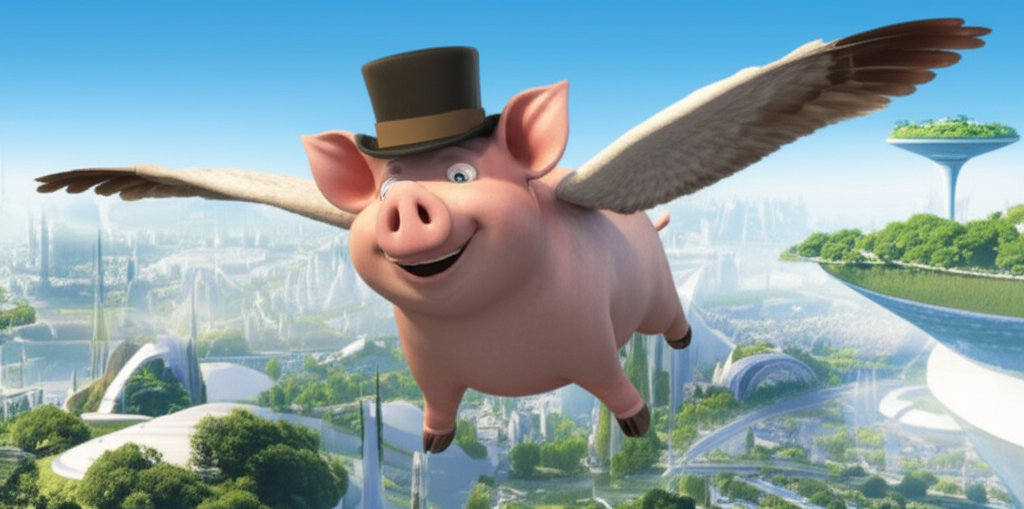

In [6]:
contents = ('Hi, can you create a 3d rendered image of a pig '
            'with wings and a top hat flying over a happy '
            'futuristic scifi city with lots of greenery?')

response = client.models.generate_content(
    model="gemini-2.0-flash-exp-image-generation",
    contents=contents,
    config=gtypes.GenerateContentConfig(
      response_modalities=['TEXT', 'IMAGE']
    )
)

for part in response.candidates[0].content.parts:
  if part.text is not None:
    print(part.text)
  elif part.inline_data is not None:
    image = Image.open(BytesIO((part.inline_data.data)))
    image.save('gemini-native-image.png')
    display(IPImage(filename='gemini-native-image.png'))

# Hugging Face Inference Providers

* [Table of Inference Providers partners](https://huggingface.co/docs/inference-providers/en/index#partners)

# GGUF

* [Diffusers documentation about GGUF](https://huggingface.co/docs/diffusers/v0.33.1/en/quantization/gguf#supported-quantization-types)
* [Overview of GGUF quantization methods | Reddit](https://www.reddit.com/r/LocalLLaMA/comments/1ba55rj/overview_of_gguf_quantization_methods/)
* [Official GGUF documentation](https://github.com/ggml-org/ggml/blob/master/docs/gguf.md)

In [ ]:
ckpt_path = (
    "https://huggingface.co/city96/FLUX.1-dev-gguf/blob/main/flux1-dev-Q4_K_S.gguf"
)
transformer = FluxTransformer2DModel.from_single_file(
    ckpt_path,
    quantization_config=GGUFQuantizationConfig(compute_dtype=torch.bfloat16),
    torch_dtype=torch.bfloat16,
)
pipe = FluxPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-dev",
    transformer=transformer,
    torch_dtype=torch.bfloat16,
)
pipe.enable_model_cpu_offload()
prompt = "A cat holding a sign that says hello world"
image = pipe(prompt, generator=torch.manual_seed(0)).images[0]
save_path = "flux-gguf.png"
image.save(save_path)

flux1-dev-Q4_K_S.gguf:   0%|          | 0.00/6.81G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/378 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/820 [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.53G [00:00<?, ?B/s]

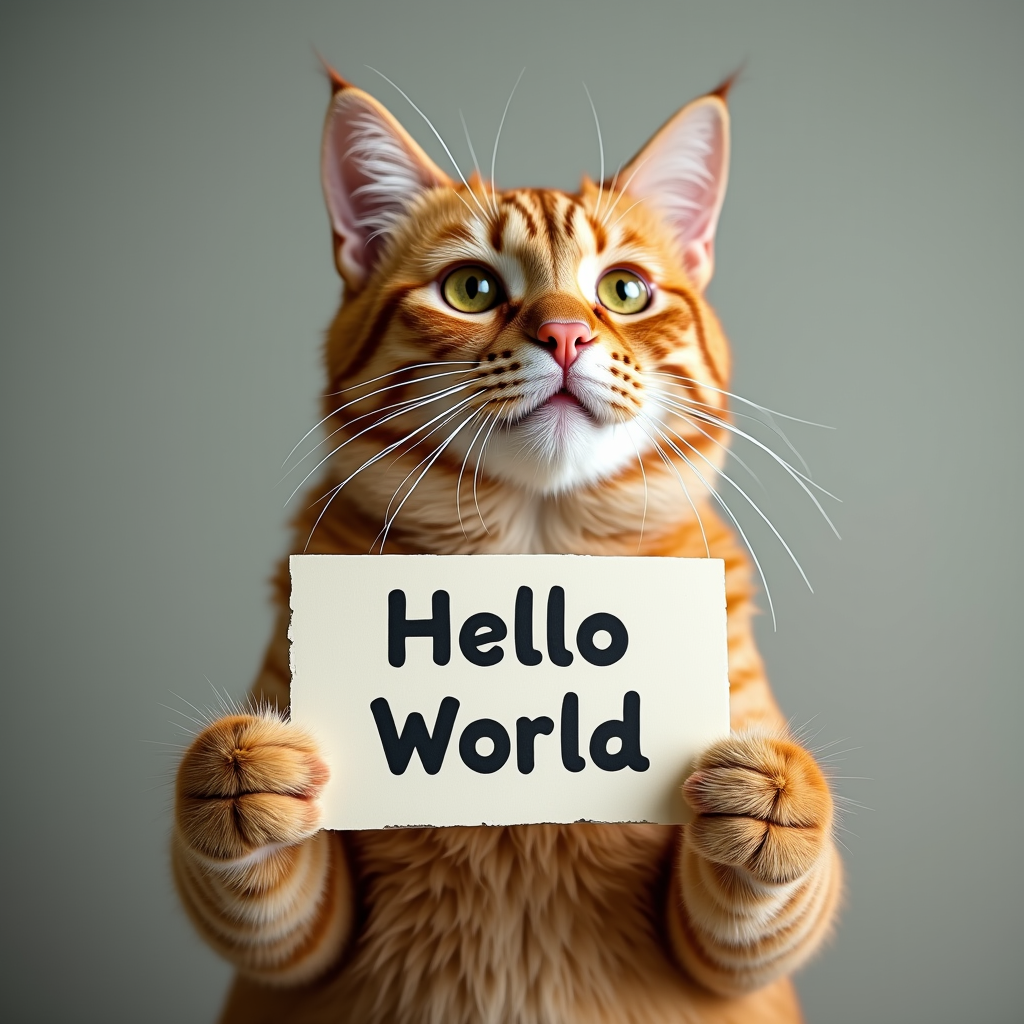

In [5]:
display(Image(filename=save_path))

## Take image + text and output image

https://huggingface.co/stabilityai/stable-diffusion-2-inpainting

For example, in a children's book, you can have the reader inserted into the world.